In [1]:
# Make necessary imports
import json
from gluonts.dataset.common import ListDataset
import os
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json
import os
import datetime
import torch

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.dataset.common import ListDataset

from pts.model.time_grad import TimeGradEstimator
from pts import Trainer

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Read in data from json files

# List to hold data about each company, will only look at 50 newest companies older than 3 years
data = []

# Timestamp 3 years ago
past_timestamp = (datetime.datetime.now() - datetime.timedelta(days=3*365)).timestamp()

# Folder where json files are found
base_path = "../datasets/stock_market_data/nyse/json/"

for filename in os.listdir(base_path):
    if filename.endswith(".json"):

        # Open JSON file 
        f = open(base_path + filename)

        # returns JSON object as a dictionary
        try:
            tmp_data = json.load(f)
        except:
            continue

        # Closing file
        f.close()

        # Check that stock has been traded for at least 3 years
        try:
            if tmp_data["chart"]["result"][0]["meta"]["firstTradeDate"] > past_timestamp:
                continue
        except:
            continue

        # Ensure that ticker is an equity
        if tmp_data["chart"]["result"][0]["meta"]["instrumentType"] != 'EQUITY':
            continue

        # Ensure ticker has a last timestamp
        try:
            tmp_data["chart"]["result"][0]["timestamp"][-1]
        except:
            continue

        # Add data about equity to data
        data.append(tmp_data)


# Sort equities by last trade timestamp
data.sort(key=lambda x: x["chart"]["result"][0]["timestamp"][-1],reverse=True)

# Only select the 50 most recently traded equities
data = data[:50]

In [17]:
data[0]["chart"]["result"][0]["indicators"].keys()

dict_keys(['quote', 'adjclose'])

In [5]:
# # Check number of timestamps in the past 3 years
# for eq in data:
#     print(min([timestamp for timestamp in eq["chart"]["result"][0]["timestamp"] if timestamp >= int(past_timestamp)]))

In [ ]:
# Preprocess data

In [6]:
# Convert data list into a glounts ListDataset

# First timestamp in past 3 years
base_timestamp = min([timestamp for timestamp in data[0]["chart"]["result"][0]["timestamp"] if timestamp >= int(past_timestamp)])

# Create training and test datasets
dataset_train = ListDataset(
    [
        {
            "target": np.array([eq["chart"]["result"][0]["indicators"]["quote"][0]["close"][-471:-100] for eq in data]),
            "start": base_timestamp,
        }
    ],
    freq="D",
    one_dim_target=False
)

dataset_test = ListDataset(
    [
        {
            "target": np.array([eq["chart"]["result"][0]["indicators"]["quote"][0]["close"][-471:-i] for eq in data]),
            "start": base_timestamp,
        }
        for i in reversed(range(7,14)) #Test on a full week
    ],
    freq="D",
    one_dim_target=False
)

In [9]:
# Train timegrad on training dataset
estimator = TimeGradEstimator(
    target_dim=50,
    prediction_length=7,
    context_length=30,
    cell_type='GRU',
    input_size=202,
    freq="1D",
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=1,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [10]:
predictor = estimator.train(dataset_train, num_workers=8)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/e

In [11]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=10)

In [12]:
forecasts = list(forecast_it)
targets = list(ts_it)

In [13]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

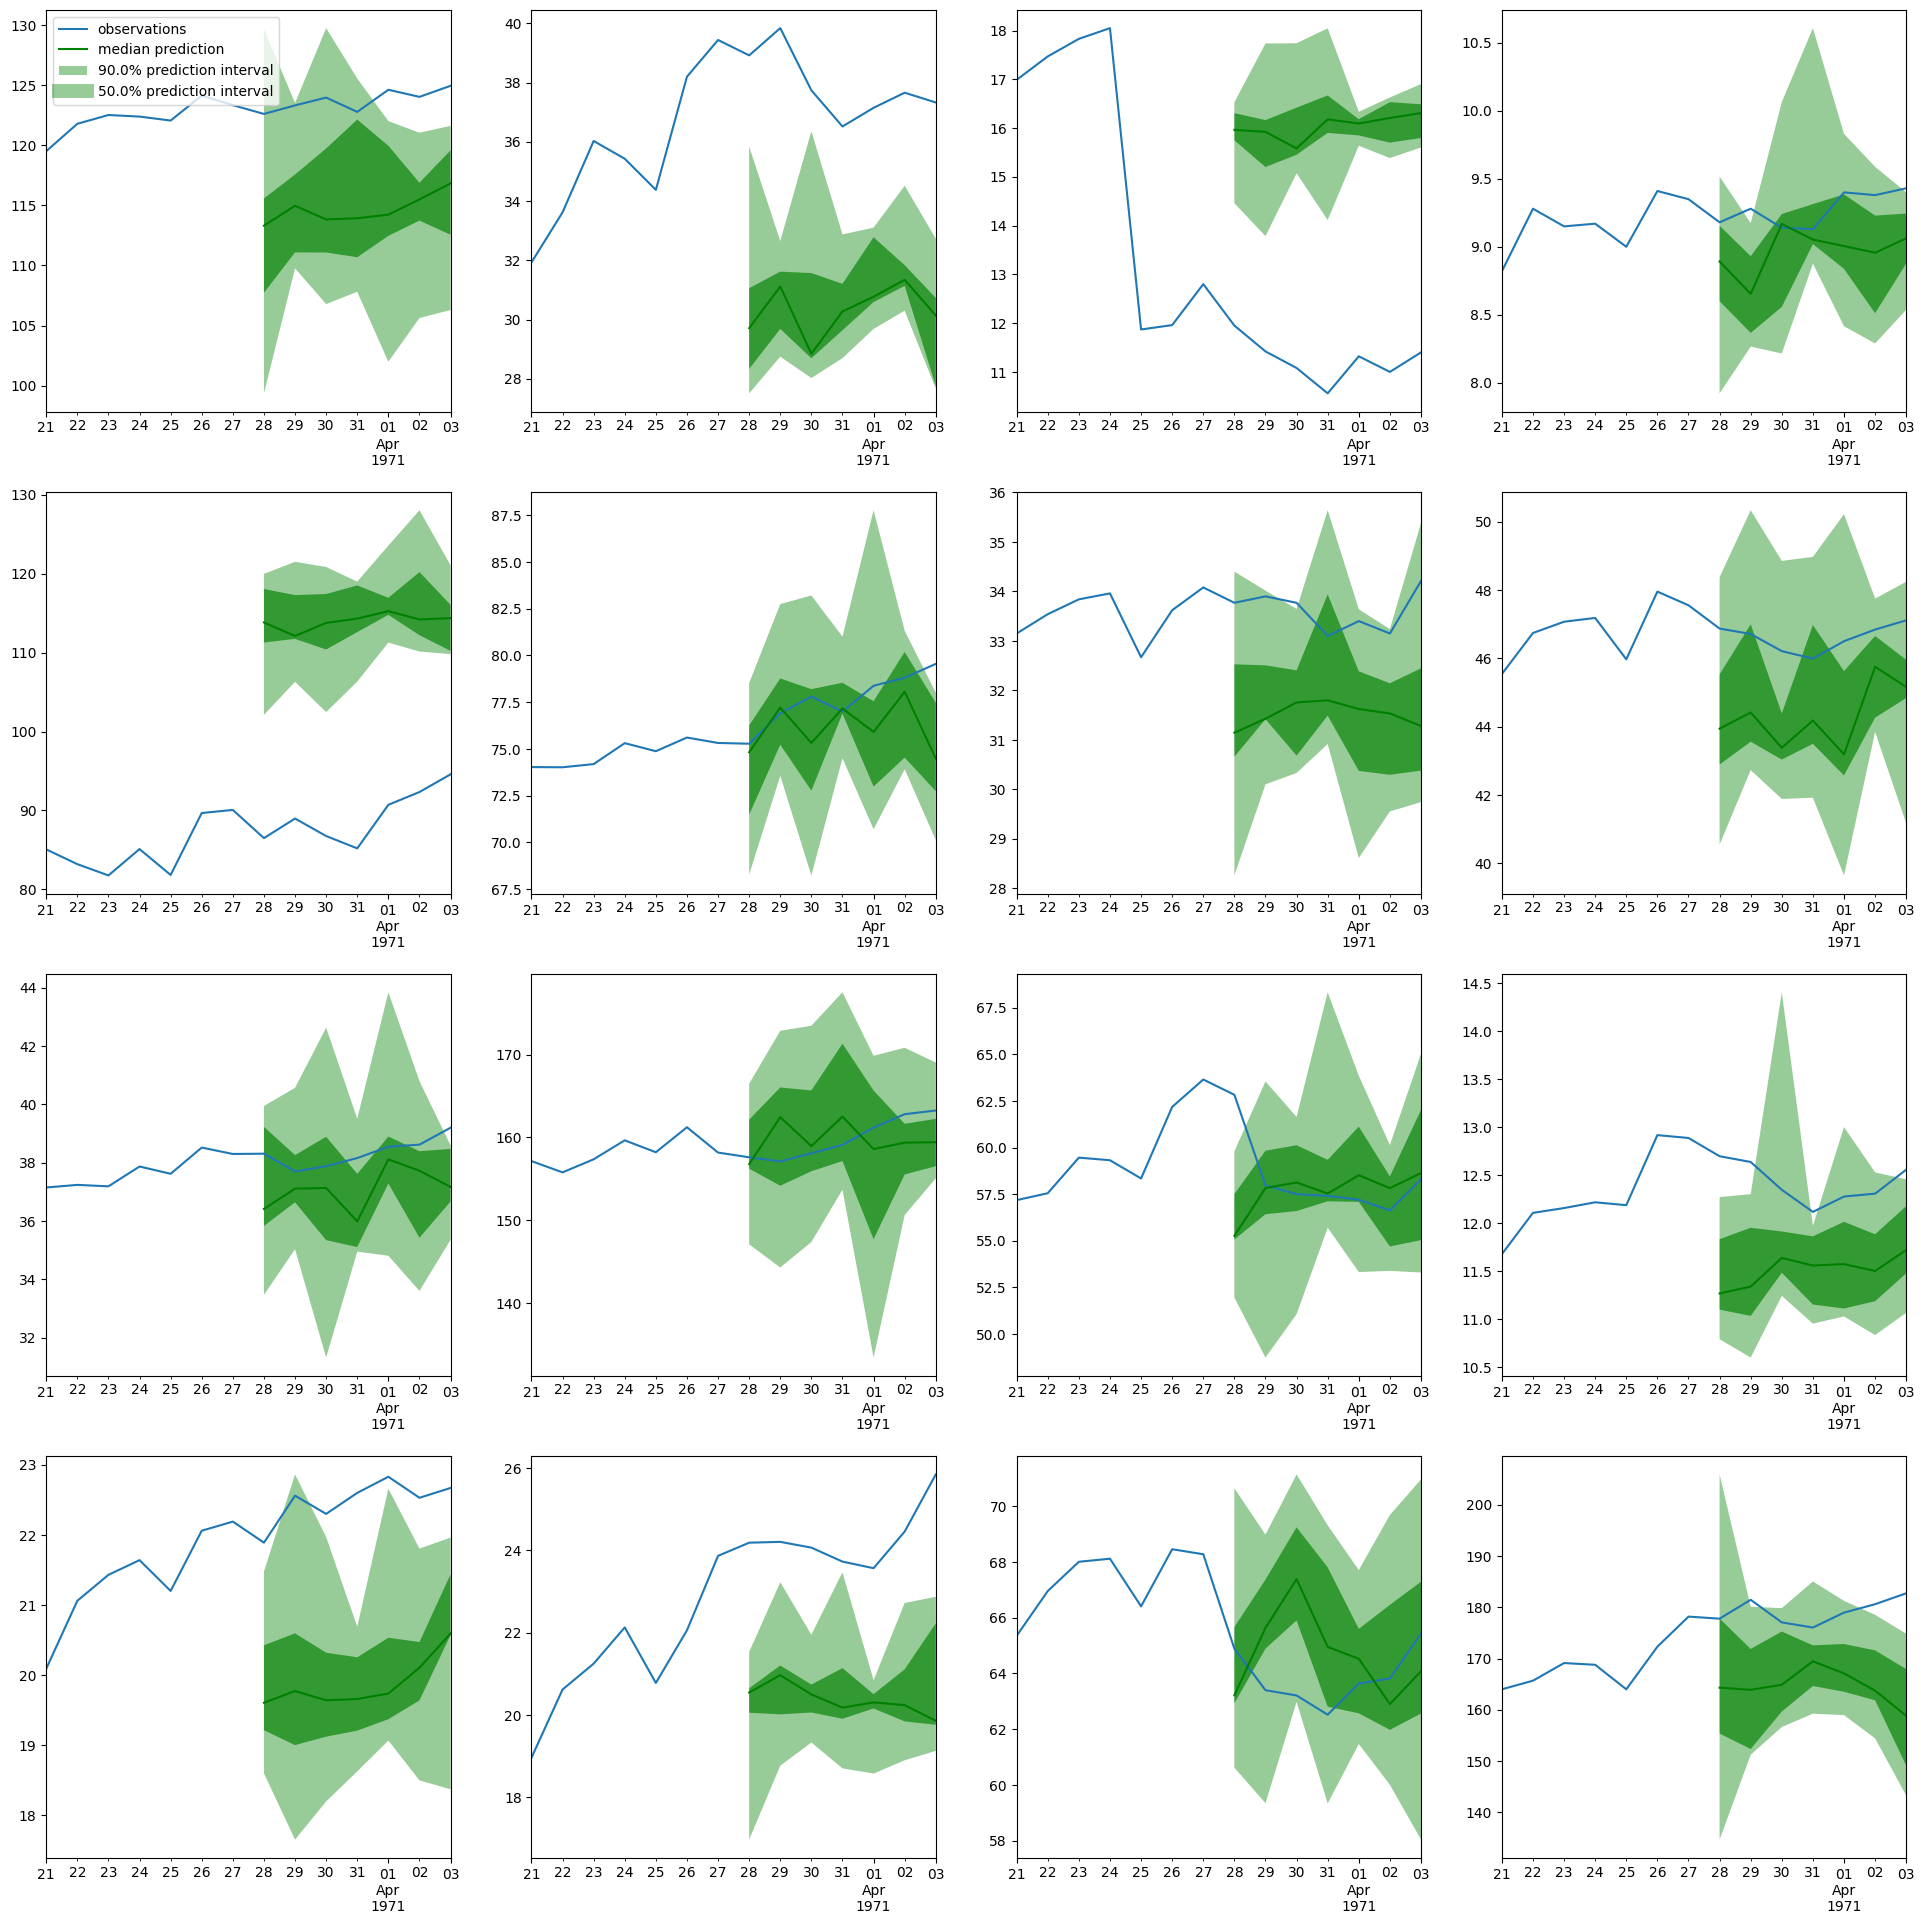

In [14]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=7,
)
plt.show()

In [15]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [16]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 223.24it/s]
Running evaluation: 7it [00:00, 252.76it/s]
Running evaluation: 7it [00:00, 258.50it/s]
Running evaluation: 7it [00:00, 260.53it/s]
Running evaluation: 7it [00:00, 256.95it/s]
Running evaluation: 7it [00:00, 267.29it/s]
Running evaluation: 7it [00:00, 239.01it/s]
Running evaluation: 7it [00:00, 261.21it/s]
Running evaluation: 7it [00:00, 266.90it/s]
Running evaluation: 7it [00:00, 254.35it/s]
Running evaluation: 7it [00:00, 258.56it/s]
Running evaluation: 7it [00:00, 260.99it/s]
Running evaluation: 7it [00:00, 229.88it/s]
Running evaluation: 7it [00:00, 214.96it/s]
Running evaluation: 7it [00:00, 225.52it/s]
Running evaluation: 7it [00:00, 215.72it/s]
Running evaluation: 7it [00:00, 223.58it/s]
Running evaluation: 7it [00:00, 217.16it/s]
Running evaluation: 7it [00:00, 231.59it/s]
Running evaluation: 7it [00:00, 226.75it/s]
Running evaluation: 7it [00:00, 224.74it/s]
Running evaluation: 7it [00:00, 228.91it/s]
Running evaluation: 7it [00:00, 

In [17]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 0.053761816608334595
ND: 0.07027316427194458
NRMSE: 0.10899187753784562

CRPS-Sum: 0.03504568370305697
ND-Sum: 0.04255155293164133
NRMSE-Sum: 0.04243459792312192


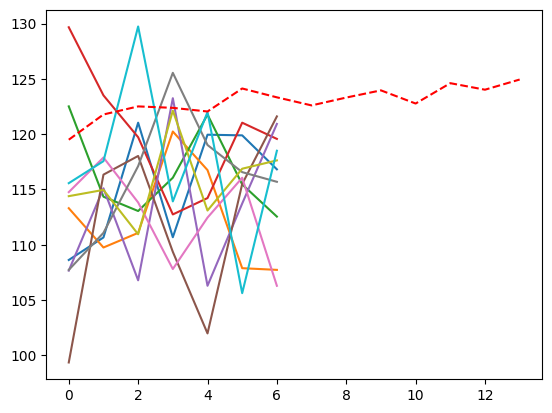

In [27]:
# Extract forecasts for 0th day and 0th test time series
for individual_forecast in forecasts[0].samples[:,:,0]: # Day 0 for stock 0
    plt.plot(individual_forecast)

# Plot corresponding target
plt.plot(list(targets[0][0])[-14:], "--r")

In [30]:
predictions = list(predictor.predict(dataset=dataset_test,num_samples=10))

In [35]:
# Access the predictions about stock 15
predictions[0].samples[:,:,15].shape


(10, 7)